In [3]:
## notebook to try creating EDFs 

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from adj_utils import load_output
import sys
sys.path.append('/glade/u/home/noahrose/ECCOv4-py')
import ecco_v4_py as ecco
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
hc_full = load_output('/glade/work/noahrose/emu_so_hc/emu_adj_301_312_3_SO_T700_full_mask_v2.bin_1/')
hc_atl = load_output('/glade/work/noahrose/emu_so_hc/emu_adj_301_312_3_SO_T700_Atl_mask_v2.bin_1/')
hc_pac = load_output('/glade/work/noahrose/emu_so_hc/emu_adj_301_312_3_SO_T700_Pac_mask_v2.bin_1/')
hc_ind = load_output('/glade/work/noahrose/emu_so_hc/emu_adj_301_312_3_SO_T700_Ind_mask_v2.bin_1/')

llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_ti

In [5]:
hc_arr = [hc_full,hc_atl,hc_pac,hc_ind]

In [6]:
varname = 'qnet'
ecco_varname = 'oceQnet'

In [7]:
ratio_ind_atl = 140./(140.+80.)
pmai_sensitivity = hc_arr[2] - (hc_arr[3] * ratio_ind_atl + hc_arr[1] * (1 - ratio_ind_atl))
#qnet_adj = pmai_sensitivity[varname]
#qnet_adj = pmai_sensitivity.tauu
qnet_adj = hc_arr[0][varname]

In [8]:
qnet_adj_norm = (qnet_adj)#-qnet_adj.mean('lag'))/qnet_adj.std('lag')

In [9]:
qnet_ecco = xr.open_mfdataset(f'/glade/work/noahrose/ECCOV4r4/nctiles_monthly/{ecco_varname}/*/*.nc')[ecco_varname]
#qnet_ecco = xr.open_mfdataset('/glade/work/noahrose/ECCOV4r4/nctiles_monthly/oceTAUE/*/*.nc').oceTAUE

In [10]:
qnet_ecco_anom = qnet_ecco.groupby('time.month') - qnet_ecco.groupby('time.month').mean('time')

In [11]:
grid = xr.open_dataset('/glade/work/noahrose/ECCOV4r4/ECCO-GRID.nc')

In [12]:
new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180


lons, lats,\
new_grid_lon_edges, new_grid_lat_edges,\
    qnet_ecco_rg =\
            ecco.resample_to_latlon(grid.XC, \
                                    grid.YC, \
                                    qnet_ecco_anom.compute(),\
                                    new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                    new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                    fill_value = np.nan, \
                                    mapping_method = 'nearest_neighbor',
                                    radius_of_influence = 120000);

In [13]:
# mask out values over land
qnet_ecco_rg = np.where((qnet_adj[100] !=0) & (lats <= 90),qnet_ecco_rg,0)

In [14]:
def plot_pattern(arr,num_patterns,text=None,figsize=(8,12),cbar_label=None,suptitle=None):
    fig,axs = plt.subplots(1,num_patterns,figsize=figsize,subplot_kw={'projection':ccrs.Orthographic(0,-90)},
                          layout='compressed')
    hr = np.nanmax(abs(arr))
    for i,ax in enumerate(axs):
        im = ax.pcolormesh(lons,lats,arr[:,i].reshape(ny,nx),cmap="RdBu_r",
                           norm=colors.CenteredNorm(halfrange=hr),transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND,facecolor='gray',zorder=100)
        ax.set_title(f'{text} {i+1}')
    fig.colorbar(im, ax=axs.ravel().tolist(),label=cbar_label)
    if (suptitle != None):
        plt.suptitle(suptitle)
    #plt.tight_layout()

In [15]:
print(qnet_ecco_rg.shape)
print(qnet_adj_norm.shape)

(312, 180, 360)
(1358, 180, 360)


In [16]:
qnet_ecco_norm = (qnet_ecco_rg)# - qnet_ecco_rg.mean())/qnet_ecco_rg.std()

In [17]:
nt,ny,nx = qnet_ecco_norm.shape
nl,_,_ = qnet_adj_norm.shape

X = qnet_ecco_norm.reshape(nt,nx*ny)
Y = qnet_adj_norm.fillna(0).to_numpy().reshape(nl,nx*ny)


In [18]:
cov = X.dot(Y.T) ## dimensions time X lag

In [19]:
U,S,V = np.linalg.svd(cov,full_matrices=False)

In [20]:
EDFs = X.T.dot(U)

#pattern1 = V[0].dot(Y)

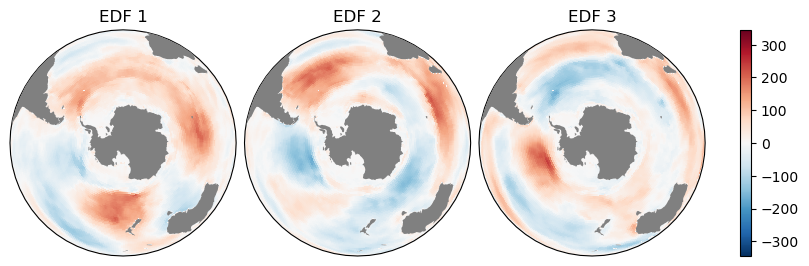

In [21]:
plot_pattern(EDFs,3,text='EDF',figsize=(8,12))

In [22]:
U_a,s_a,V_a = np.linalg.svd(Y,full_matrices=False)
SOs = Y.T.dot(U_a)

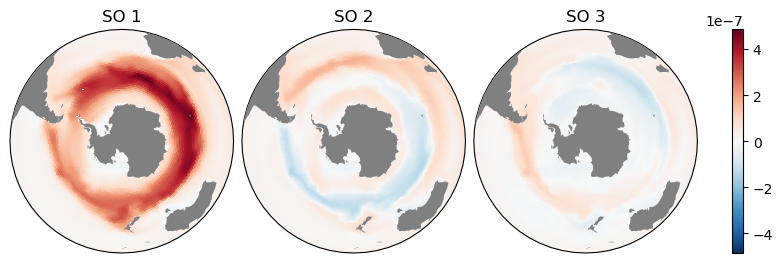

In [23]:
plot_pattern(SOs,3,'SO',figsize=(8,12))

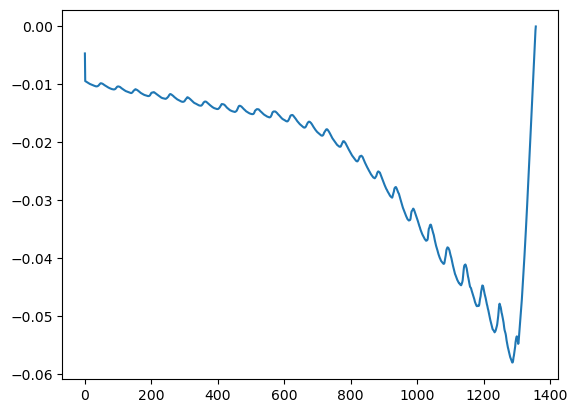

In [24]:
plt.plot(U_a[:,0])

In [25]:
U_f,s_f,V_f = np.linalg.svd(X,full_matrices=False)
EOFs = X.T.dot(U_f)

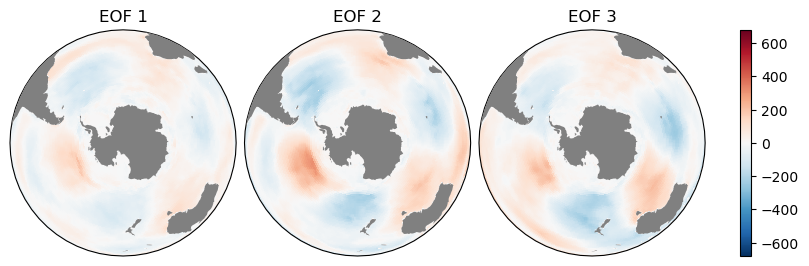

In [26]:
plot_pattern(EOFs,3,'EOF',figsize=(8,12))

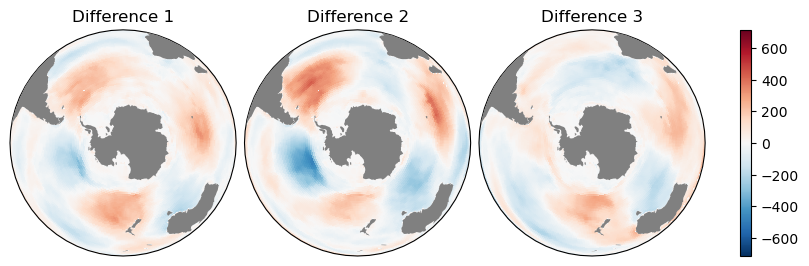

In [27]:
plot_pattern(-(EOFs-EDFs),3,'Difference',figsize=(8,12))

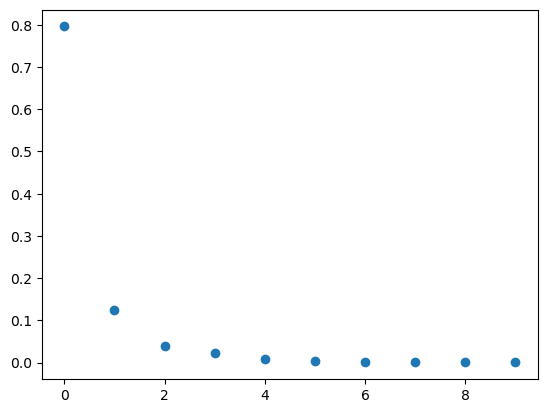

In [28]:
plt.plot((S**2/(S**2).sum())[:10],'o')

Hi Dan, I've been trying to pencil this out and have a problem. My SO matrix has dimensions of (SO number) X (lag) and my data matrix U has dimensions (space) X (lag). The SO number and space have the same rank, so I can take the product S.T U, but I'm not sure it means anything. Alternatively, I could calculate the EDFs and project them onto the SO basis to look at which SOs contribute to the leading EDFs, but that seems a little circular to me. Any ideas?
11:28
Or, I could project the SOs back onto the adjoint sensitivities to get a matrix of SO spatial patterns (SO number X space) and multiply that by U to get a matrix of (SO number X time) and SVD that








In [29]:
SOs.shape

(64800, 1358)

In [30]:
X.shape

(312, 64800)

In [31]:
SO_X = SOs.T.dot(X.T)
U_x,s_x,_ = np.linalg.svd(SO_X)

Text(0, 0.5, 'percent variance explained')

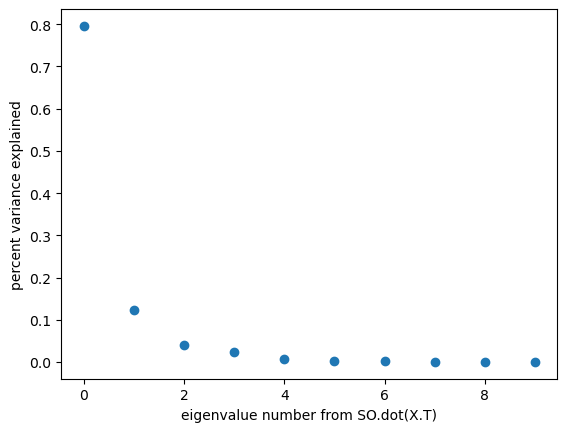

In [32]:
plt.plot((s_x[:10])**2/(s_x**2).sum(),'o')
plt.xlabel('eigenvalue number from SO.dot(X.T)')
plt.ylabel('percent variance explained')

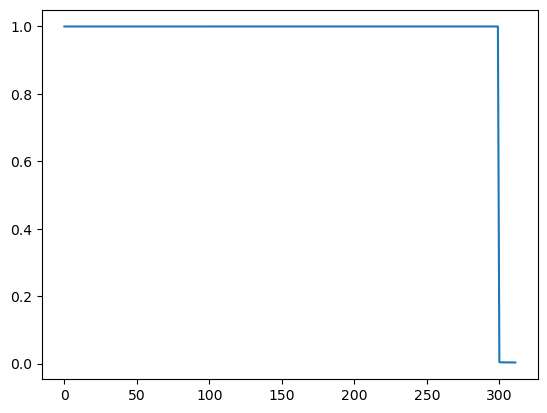

In [33]:
plt.plot(s_x/S)

Text(0.5, 1.0, 'Left singular vector #1 of (SO.dot(X.T))')

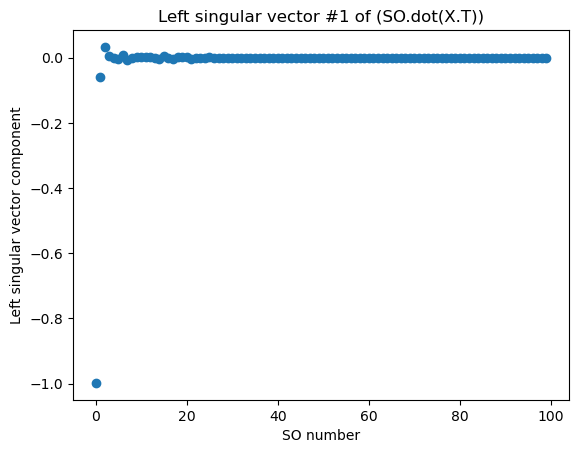

In [34]:
plt.plot(U_x[:100,0],'o')
plt.xlabel('SO number')
plt.ylabel('Left singular vector component')
plt.title('Left singular vector #1 of (SO.dot(X.T))')

In [35]:
i = 0
cov_i = X.dot((Y[:-104*i]).T)
cov_i

array([], shape=(312, 0), dtype=float32)

In [36]:
cov_i

array([], shape=(312, 0), dtype=float32)

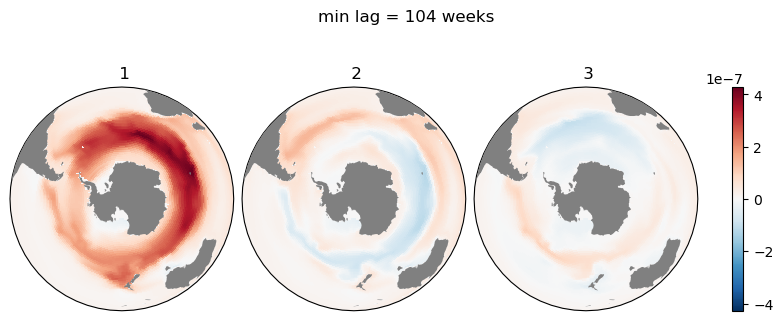

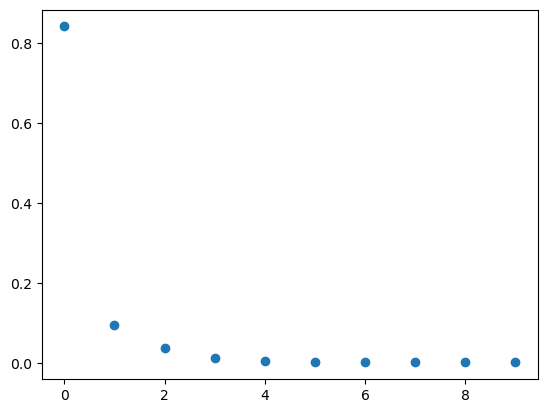

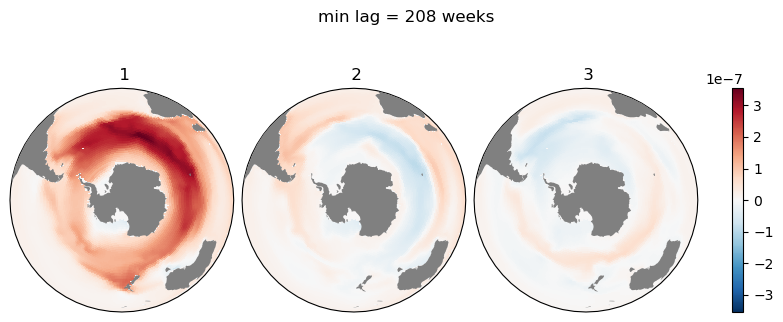

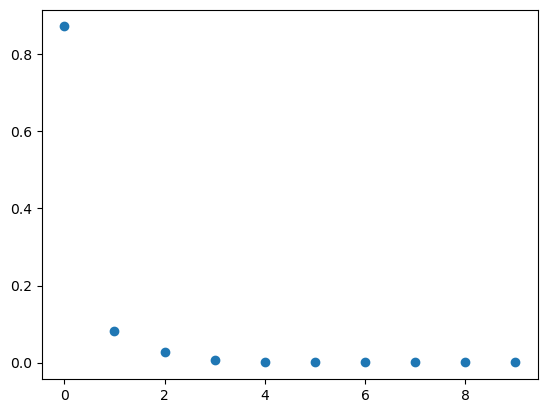

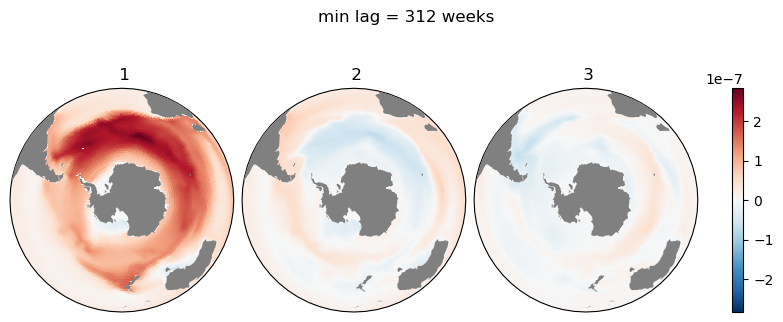

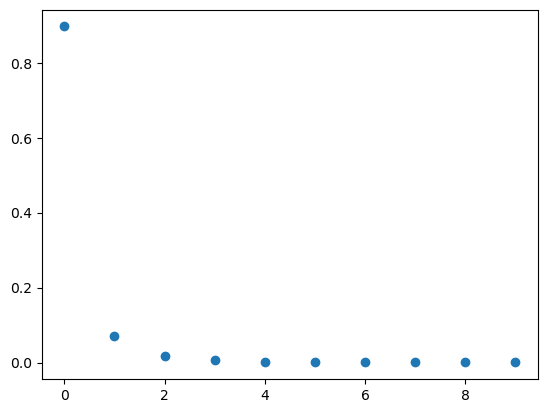

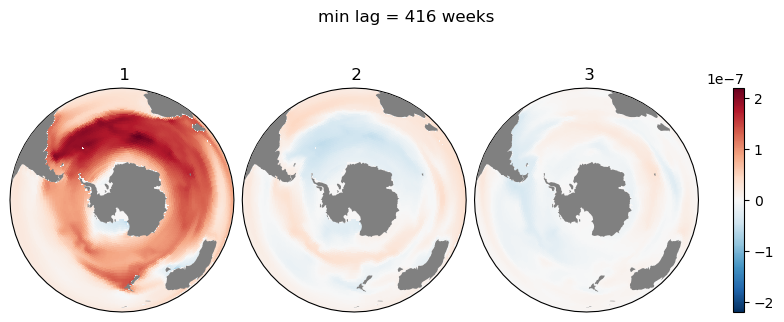

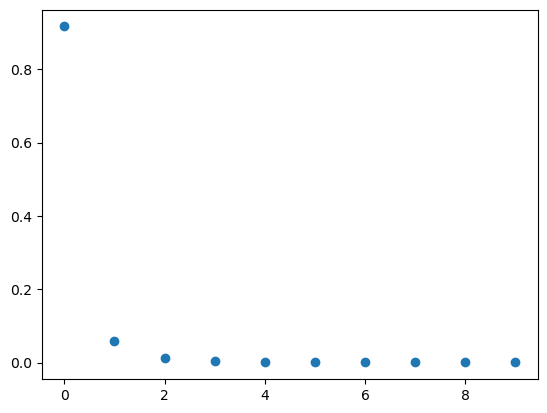

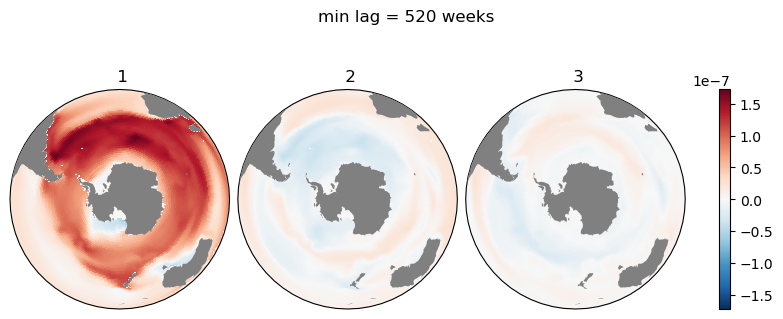

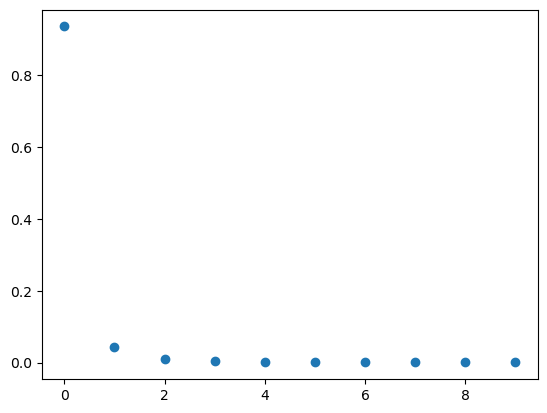

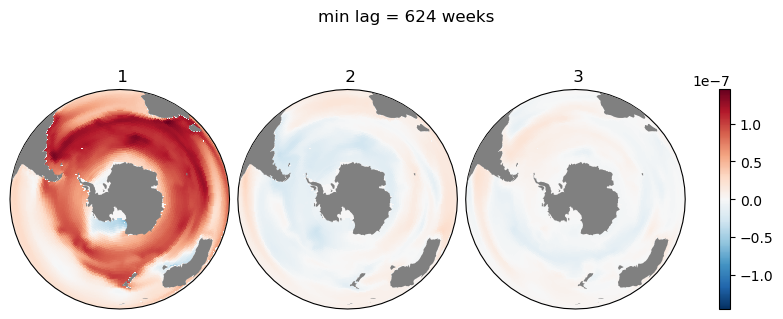

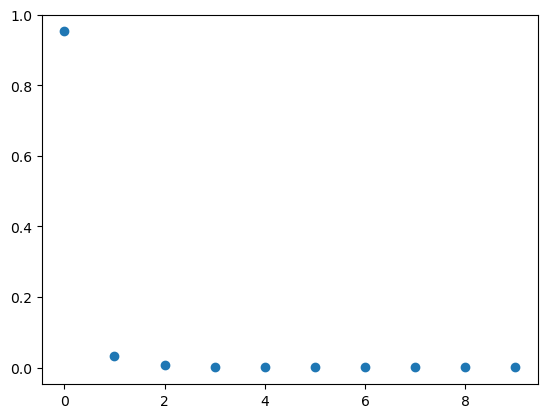

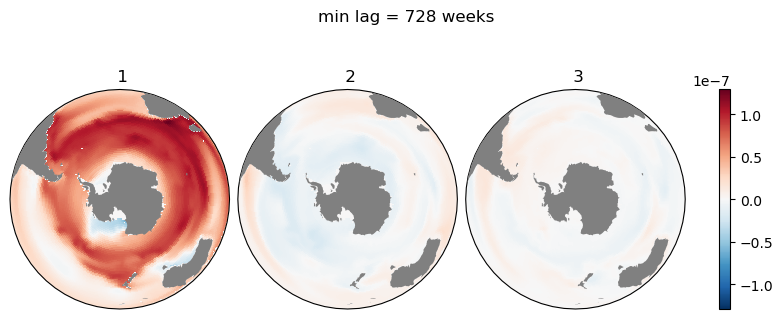

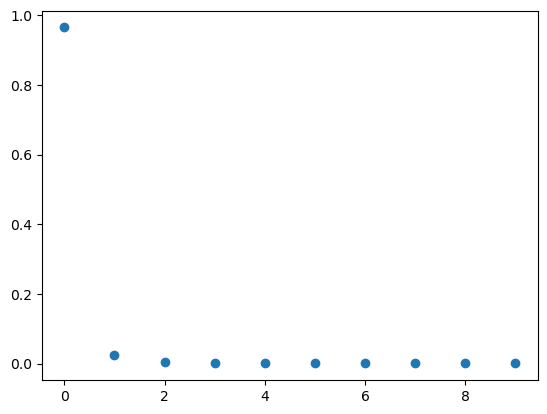

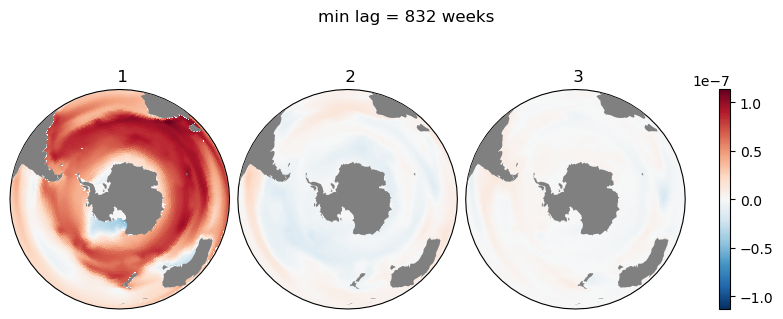

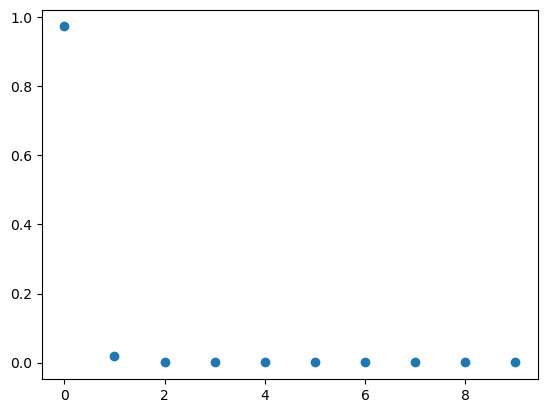

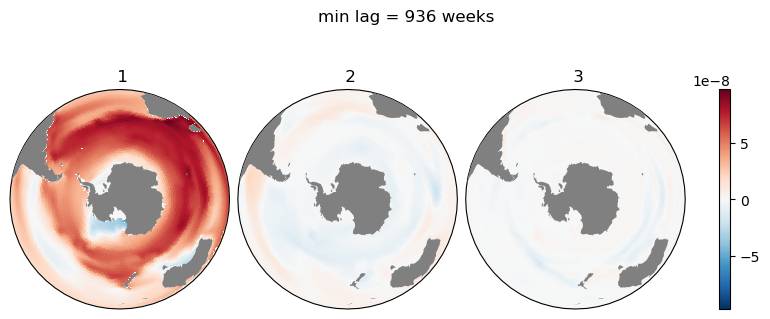

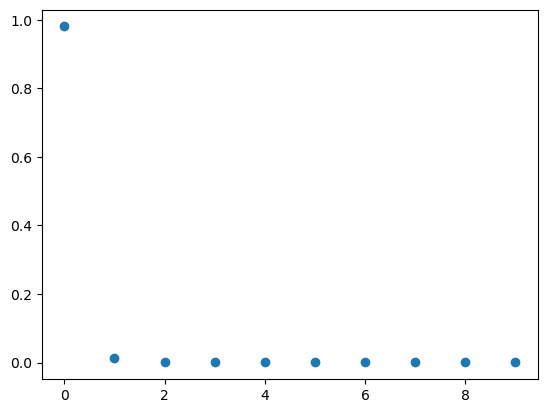

In [37]:
for i in range(1,10):

    cov_i = X.dot((Y[:-104*i]).T) ## dimensions time X lag
    
    U_i,S_i,V_i = np.linalg.svd(Y[:-104*i],full_matrices=False)#np.linalg.svd(cov_i,full_matrices=False)
    
    #EDFs_i = X.T.dot(U_i)
    
    SOs_i = Y[:-104*i].T.dot(U_i)
    
    plot_pattern(SOs_i,3,text='',figsize=(8,12))
    plt.suptitle(f'min lag = {i*104} weeks',y=0.65)
    plt.show()
    plt.plot((S_i[:10])**2/(S_i**2).sum(),'o')


In [38]:
Y.shape

(1358, 64800)

In [39]:
X.shape

(312, 64800)

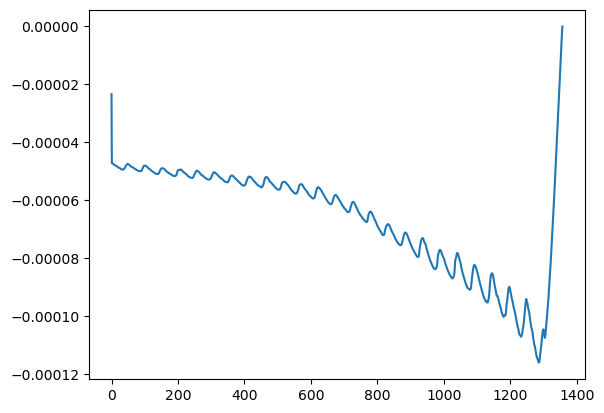

In [40]:
plt.plot(np.sum(Y,axis=-1))

In [41]:
reg = SOs_i[:,0].dot(Y.T)/np.linalg.norm(SOs_i[:,0])

In [42]:
Y_p = Y - np.outer(reg,SOs_i[:,0])/np.linalg.norm(SOs_i[:,0])

In [43]:
U_p,s_p,_ = np.linalg.svd(Y_p,full_matrices=False)

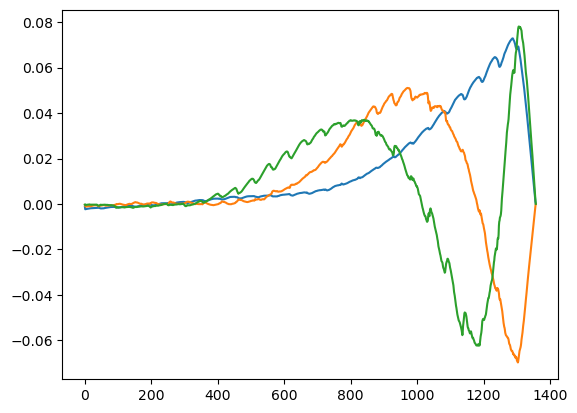

In [44]:
plt.plot(U_p[:,:3])

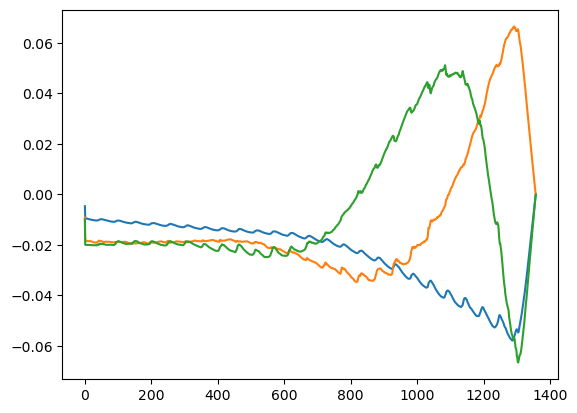

In [45]:
plt.plot(U_a[:,:3])

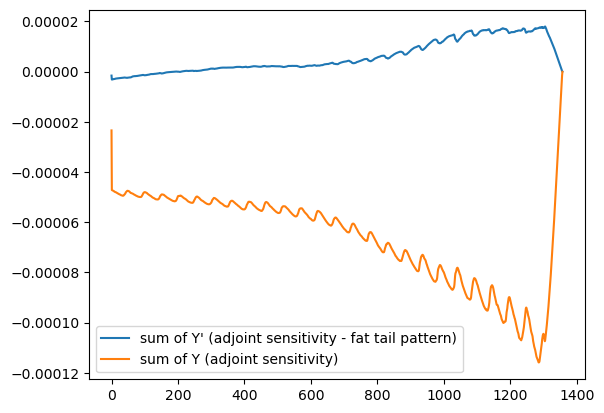

In [46]:
plt.plot(np.sum(Y_p,axis=1),label='sum of Y\' (adjoint sensitivity - fat tail pattern)')
plt.plot(np.sum(Y,axis=1),label = 'sum of Y (adjoint sensitivity)')
plt.legend()

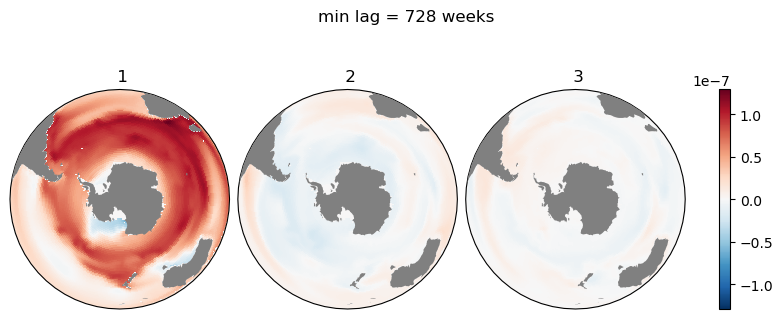

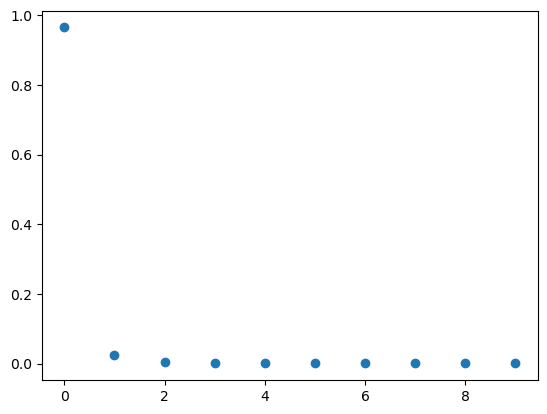

In [47]:
i = 7

cov_i = X.dot((Y[:-104*i]).T) ## dimensions time X lag

U_i,S_i,V_i = np.linalg.svd(Y[:-104*i],full_matrices=False)#np.linalg.svd(cov_i,full_matrices=False)

#EDFs_i = X.T.dot(U_i)

SOs_i = Y[:-104*i].T.dot(U_i)

plot_pattern(SOs_i,3,text='',figsize=(8,12))
plt.suptitle(f'min lag = {i*104} weeks',y=0.65)
plt.show()
plt.plot((S_i[:10])**2/(S_i**2).sum(),'o')

In [48]:
from scipy.optimize import curve_fit

exp_fxn = lambda t,a,b: a*np.exp(b*t)
lags_ui = np.arange(1358,1358+(U_i[:,0].shape[0]))
a,b = curve_fit(exp_fxn, lags_ui,  U_i[::-1,0],  p0=(-1, -0.0001))[0]

In [49]:
U_i[:,0].shape[0]

630

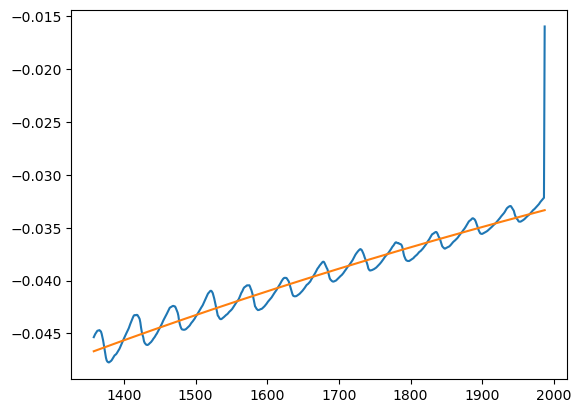

In [50]:
plt.plot(lags_ui,U_i[::-1,0])
plt.plot(lags_ui,a*np.exp(b*lags_ui))

In [51]:
exp_100yr = a * np.exp(np.arange(0,5200)*b) 

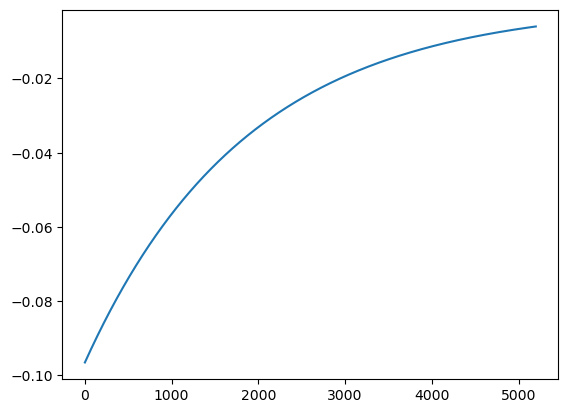

In [52]:
plt.plot(exp_100yr)

In [53]:
fattail_pattern = np.outer(SOs_i[:,0],exp_100yr).T

In [54]:
fattail_pattern.shape

(5200, 64800)

In [55]:
Y_pad = np.pad(Y,((5200-1358,0),(0,0)))

In [56]:
Y_t = Y_pad[::-1] + np.pad(fattail_pattern[1357:,:],((1357,0),(0,0)))

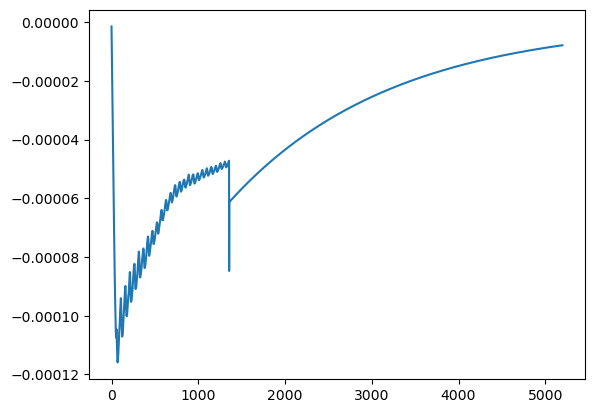

In [57]:
plt.plot(np.sum(Y_t[1:],axis=-1))

In [58]:
Y_pad.shape

(5200, 64800)

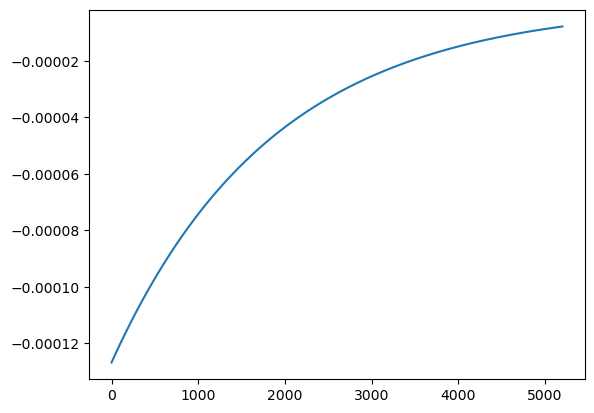

In [59]:
plt.plot(fattail_pattern.sum(axis = -1))

In [60]:
ftp_Y_ratio

NameError: name 'ftp_Y_ratio' is not defined

In [ ]:
Y[1].sum()/fattail_pattern[1358].sum()

In [ ]:
Y[1].sum()